In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display

In [0]:
# !unzip -q ml-100k.zip
# !rm ml-100k.zip

In [0]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', \
          'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', \
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', \
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

In [4]:
users['user_id'] = users['user_id'].astype('object')
users.drop(columns=['zip_code'], inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 4 columns):
user_id       943 non-null object
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
dtypes: int64(1), object(3)
memory usage: 29.6+ KB


In [5]:
display(users.describe(exclude='object'))
display(users.describe(include='object'))

,age
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


,user_id,sex,occupation
count,943,943,943
unique,943,2,21
top,943,M,student
freq,1,670,196


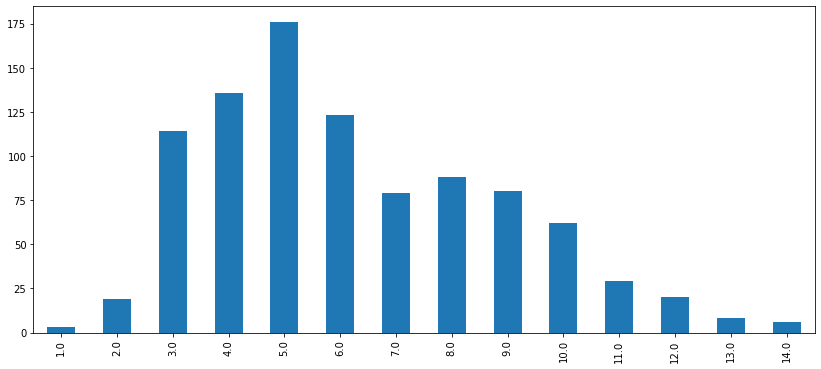

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
users['age'] = KBinsDiscretizer(n_bins=14, encode='ordinal', \
                                strategy='uniform').fit_transform(users['age'].\
                                                                  values.reshape(-1, 1)).\
                                                                  squeeze()
users['age'] = users['age'] + 1 # (0 to 13) ==> (1 to 14)

users['age'].value_counts(sort=False).sort_index().plot(kind='bar', figsize=(14, 6));

In [7]:
users['sex'] = users['sex'].apply(lambda x: -1 if x == 'F' else 1)
users['sex']

0      1
1     -1
2      1
3      1
4     -1
      ..
938   -1
939    1
940    1
941   -1
942    1
Name: sex, Length: 943, dtype: int64

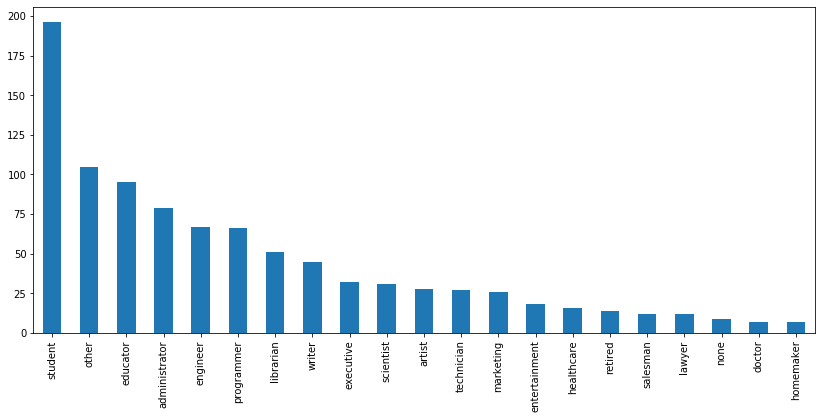

In [8]:
users['occupation'].value_counts().plot(kind='bar', figsize=(14, 6));

In [0]:
ratings['user_id'] = ratings['user_id'].astype('object')
ratings['movie_id'] = ratings['movie_id'].astype('object')

ratings.drop(columns=['unix_timestamp'], inplace=True)

In [0]:
# 'unknown' column only contain only two '1'
items.drop(columns=['release date', 'video release date', 'IMDb URL', 'unknown'],
           inplace=True)

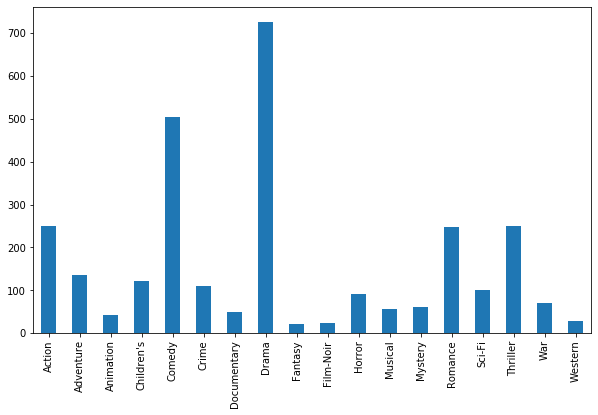

In [11]:
items.iloc[:, 2:].sum().plot(kind='bar', figsize=(10, 6));

In [12]:
items.head(3)

,movie id,movie title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
def df2dict(df):
    id2movie, movie2id, id2feature = {}, {}, {}
    for idx in df.index:
        id2movie[df.iloc[idx, 0]] = df.iloc[idx, 1]
        movie2id[df.iloc[idx, 1]] = df.iloc[idx, 0]
        id2feature[df.iloc[idx, 0]] = np.array(df.iloc[idx, 2:].values, dtype=np.int64)

    return id2movie, movie2id, id2feature

id2movie, movie2id, id2feature = df2dict(items)

In [14]:
print(id2movie[1], movie2id['Toy Story (1995)'], id2feature[1], sep='\n')

Toy Story (1995)
1
[0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
n_users = users.shape[0]
n_items = items.shape[0]

ui_matrix = np.zeros((n_users, n_items)) # user-item matrix

for (_, user_id, item_id, rating) in ratings.itertuples():
    ui_matrix[user_id-1, item_id-1] = rating

In [16]:
ui_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [0]:
from sklearn.metrics import pairwise_distances as distance
import seaborn as sns

In [0]:
user_similarity = distance(ui_matrix, metric='cosine', n_jobs=-1)
item_similarity = distance(ui_matrix.T, metric='cosine', n_jobs=-1)

In [31]:
user_similarity

array([[2.22044605e-15, 8.33069016e-01, 9.52540457e-01, ...,
        8.51383057e-01, 8.20492117e-01, 6.01825261e-01],
       [8.33069016e-01, 0.00000000e+00, 8.89408675e-01, ...,
        8.38515222e-01, 8.27732187e-01, 8.94202122e-01],
       [9.52540457e-01, 8.89408675e-01, 0.00000000e+00, ...,
        8.98757435e-01, 8.66583851e-01, 9.73444131e-01],
       ...,
       [8.51383057e-01, 8.38515222e-01, 8.98757435e-01, ...,
        0.00000000e+00, 8.98358201e-01, 9.04880419e-01],
       [8.20492117e-01, 8.27732187e-01, 8.66583851e-01, ...,
        8.98358201e-01, 1.11022302e-16, 8.17535338e-01],
       [6.01825261e-01, 8.94202122e-01, 9.73444131e-01, ...,
        9.04880419e-01, 8.17535338e-01, 0.00000000e+00]])

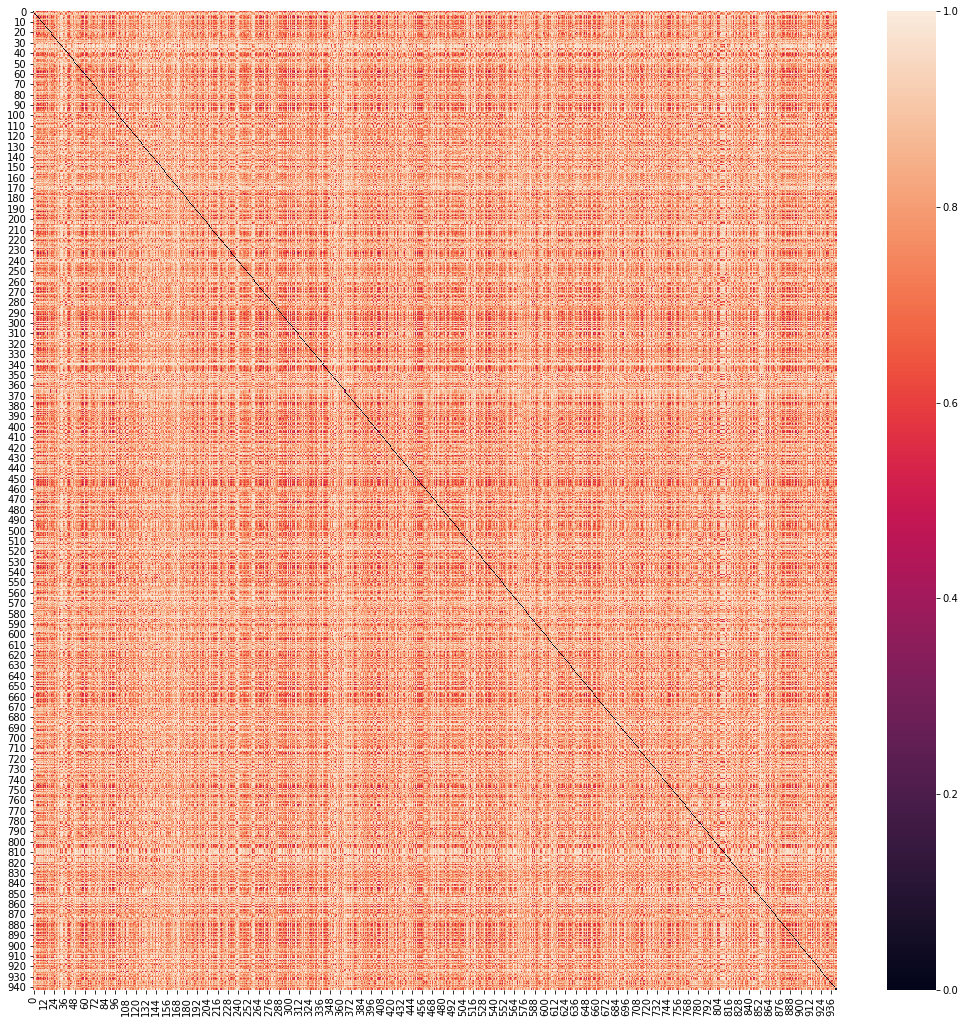

In [22]:
plt.figure(figsize=(18, 18))
sns.heatmap(user_similarity);

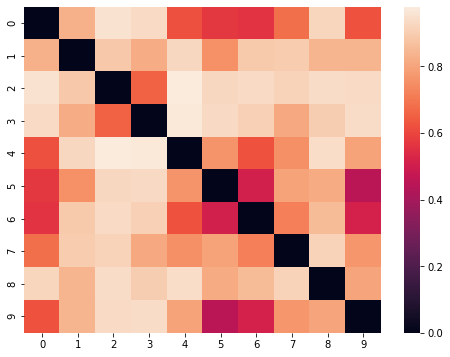

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(user_similarity[:10, :10]);

In [39]:
user_similarity[:4, :4]

array([[2.22044605e-15, 8.33069016e-01, 9.52540457e-01, 9.35642176e-01],
       [8.33069016e-01, 0.00000000e+00, 8.89408675e-01, 8.21878808e-01],
       [9.52540457e-01, 8.89408675e-01, 0.00000000e+00, 6.55849283e-01],
       [9.35642176e-01, 8.21878808e-01, 6.55849283e-01, 0.00000000e+00]])